In [1]:
!ls FACS

annotations_FACS.csv  FACS  FACS.zip  metadata_FACS.csv


In [2]:
!ls FACS/FACS

Bladder-counts.csv	    Kidney-counts.csv	Pancreas-counts.csv
Brain_Microglia-counts.csv  Liver-counts.csv	Skin-counts.csv
Brain_Neurons-counts.csv    Lung-counts.csv	Spleen-counts.csv
Colon-counts.csv	    Mammary-counts.csv	Thymus-counts.csv
Fat-counts.csv		    Marrow-counts.csv	Tongue-counts.csv
Heart-counts.csv	    Muscle-counts.csv	Trachea-counts.csv


In [3]:
import os
from glob import glob

import numpy as np
import pandas as pd
import scanpy as sc
from scanpy.tl import louvain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_ind

%matplotlib inline

In [4]:
target_dataset = 'Brain_Neurons'

In [5]:
count_df = pd.read_csv(f'./FACS/FACS/{target_dataset}-counts.csv', index_col=0).transpose()
count_df.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
E19.MAA000538.3_8_M.1.1,0,162,0,0,3,1,0,0,0,0,...,0,0,0,9,0,0,1,0,0,0
M6.MAA000538.3_8_M.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P7.MAA000538.3_8_M.1.1,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,1,8,0,0,0,0
F5.MAA000538.3_8_M.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M7.MAA000538.3_8_M.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
count_df.shape

(5799, 23433)

In [7]:
annotations_df = pd.read_csv('./FACS/annotations_FACS.csv', index_col=0)
annotations_df.head()

,tissue,cell_ontology_class,cell_ontology_term_iri,cell_ontology_id
cell,,,,
A21.MAA000594.3_8_M.1.1,Aorta,fibroblast,http://purl.obolibrary.org/obo/CL_0000057,CL:0000057
F8.MAA000594.3_8_M.1.1,Aorta,unknown,NaN,CL:.
H11.MAA000594.3_8_M.1.1,Aorta,unknown,NaN,CL:.
A22.MAA000594.3_8_M.1.1,Aorta,unknown,NaN,CL:.
H12.MAA000594.3_8_M.1.1,Aorta,epicardial adipocyte,http://purl.obolibrary.org/obo/CL_1000309,CL:1000309


In [8]:
annotations_df.shape

(42192, 4)

In [9]:
metadata_df = pd.read_csv('./FACS/metadata_FACS.csv', index_col=0)
metadata_df.head()

,mouse.id,tissue,subtissue,FACS.selection,mouse.sex
plate.barcode,,,,,
D041914,3_8_M,Bladder,NaN,Multiple,M
D042253,3_9_M,Bladder,NaN,Multiple,M
MAA000487,3_10_M,Bladder,NaN,Multiple,M
B000610,3_56_F,Bladder,NaN,Multiple,F
B002764,3_38_F,Bladder,NaN,Multiple,F


In [10]:
combined_df = pd.merge(count_df, annotations_df, how ='inner', left_index=True, right_on = 'cell')
combined_df.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene,tissue,cell_ontology_class,cell_ontology_term_iri,cell_ontology_id
cell,,,,,,,,,,,,,,,,,,,,,
E19.MAA000538.3_8_M.1.1,0,162,0,0,3,1,0,0,0,0,...,0,0,1,0,0,0,Brain_Neurons,Bergmann glial cell,http://purl.obolibrary.org/obo/CL_0000644,CL:0000644
F11.MAA000538.3_8_M.1.1,0,37,7,0,30,0,3,0,0,14,...,0,0,126,0,31,0,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128
H11.MAA000538.3_8_M.1.1,0,10,107,0,0,0,0,0,0,0,...,0,9,0,0,1,0,Brain_Neurons,neuron,http://purl.obolibrary.org/obo/CL_0000540,CL:0000540
J7.MAA000538.3_8_M.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,Brain_Neurons,unknown,NaN,CL:.
K3.MAA000538.3_8_M.1.1,0,790,0,0,21,0,0,0,0,312,...,2,0,0,0,0,0,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128


In [11]:
filtered_count_df = combined_df[count_df.columns]
filtered_count_df.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
cell,,,,,,,,,,,,,,,,,,,,,
E19.MAA000538.3_8_M.1.1,0,162,0,0,3,1,0,0,0,0,...,0,0,0,9,0,0,1,0,0,0
F11.MAA000538.3_8_M.1.1,0,37,7,0,30,0,3,0,0,14,...,0,2,0,0,0,0,126,0,31,0
H11.MAA000538.3_8_M.1.1,0,10,107,0,0,0,0,0,0,0,...,0,0,0,9,0,9,0,0,1,0
J7.MAA000538.3_8_M.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
K3.MAA000538.3_8_M.1.1,0,790,0,0,21,0,0,0,0,312,...,0,0,0,0,2,0,0,0,0,0


In [12]:
obs_df = combined_df[annotations_df.columns]
obs_df.head()

,tissue,cell_ontology_class,cell_ontology_term_iri,cell_ontology_id
cell,,,,
E19.MAA000538.3_8_M.1.1,Brain_Neurons,Bergmann glial cell,http://purl.obolibrary.org/obo/CL_0000644,CL:0000644
F11.MAA000538.3_8_M.1.1,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128
H11.MAA000538.3_8_M.1.1,Brain_Neurons,neuron,http://purl.obolibrary.org/obo/CL_0000540,CL:0000540
J7.MAA000538.3_8_M.1.1,Brain_Neurons,unknown,NaN,CL:.
K3.MAA000538.3_8_M.1.1,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128


In [13]:
adata = sc.AnnData(X=filtered_count_df, obs=obs_df)
adata.shape

/tmp/ipykernel_84643/826056540.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=filtered_count_df, obs=obs_df)


(3000, 23433)

In [14]:
adata.var.head()

""
0610005C13Rik
0610007C21Rik
0610007L01Rik
0610007N19Rik
0610007P08Rik


In [15]:
adata.obs.head()

,tissue,cell_ontology_class,cell_ontology_term_iri,cell_ontology_id
cell,,,,
E19.MAA000538.3_8_M.1.1,Brain_Neurons,Bergmann glial cell,http://purl.obolibrary.org/obo/CL_0000644,CL:0000644
F11.MAA000538.3_8_M.1.1,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128
H11.MAA000538.3_8_M.1.1,Brain_Neurons,neuron,http://purl.obolibrary.org/obo/CL_0000540,CL:0000540
J7.MAA000538.3_8_M.1.1,Brain_Neurons,unknown,NaN,CL:.
K3.MAA000538.3_8_M.1.1,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128


## Find Spike-ins

In [16]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in
        
adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)

found this many spike ins:  92


In [17]:
qc = sc.pp.calculate_qc_metrics(adata, qc_vars=['ERCC'])

cell_qc_df = qc[0]
gene_qc_df = qc[1]

In [18]:
cell_qc_df.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_ERCC,log1p_total_counts_ERCC,pct_counts_ERCC
cell,,,,,,,,,,,
E19.MAA000538.3_8_M.1.1,4349,8.377931,316037.0,12.663618,53.555755,58.810835,64.899363,74.961160,2875.0,7.964156,0.909704
F11.MAA000538.3_8_M.1.1,5018,8.520986,568979.0,13.251600,53.646795,58.794437,64.862148,74.575687,3075.0,8.031385,0.540442
H11.MAA000538.3_8_M.1.1,4822,8.481151,328283.0,12.701634,49.755242,53.979950,59.615332,70.321339,2133.0,7.665753,0.649744
J7.MAA000538.3_8_M.1.1,521,6.257668,80562.0,11.296795,86.528388,93.655818,98.449641,99.973933,22105.0,10.003604,27.438494
K3.MAA000538.3_8_M.1.1,3084,8.034307,1744186.0,14.371799,51.540260,58.684108,66.720751,80.258069,40326.0,10.604776,2.312024


In [19]:
gene_qc_df.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
0610005C13Rik,23,0.071667,0.069215,99.233333,215.0,5.375278
0610007C21Rik,2091,150.516663,5.020696,30.300000,451550.0,13.020444
0610007L01Rik,807,23.936333,3.216326,73.100000,71809.0,11.181779
0610007N19Rik,224,4.129667,1.635041,92.533333,12389.0,9.424645
0610007P08Rik,486,10.571000,2.448502,83.800000,31713.0,10.364513


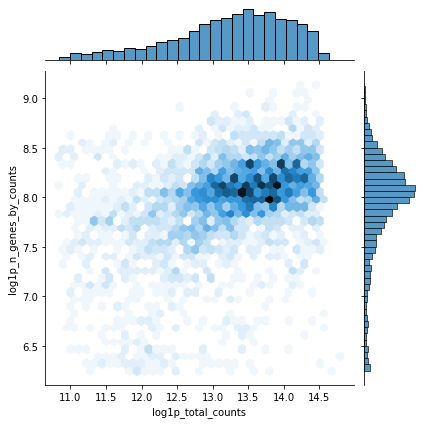

In [20]:
sns.jointplot(data=cell_qc_df,
              x='log1p_total_counts',
              y='log1p_n_genes_by_counts',
              kind='hex')

<AxesSubplot:xlabel='pct_counts_ERCC', ylabel='Count'>

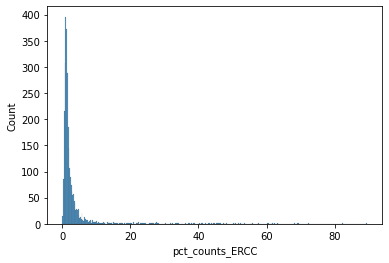

In [21]:
sns.histplot(cell_qc_df['pct_counts_ERCC'])

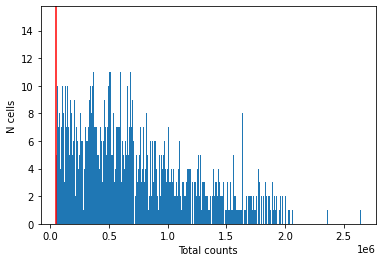

In [22]:
plt.hist(cell_qc_df['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red')

In [23]:
sum(cell_qc_df['total_counts'] < 50000)

0

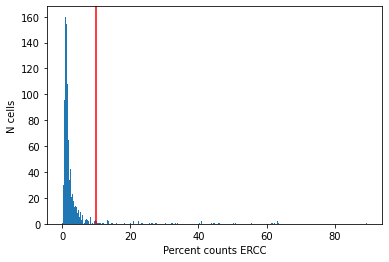

In [24]:
plt.hist(cell_qc_df['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percent counts ERCC')
plt.ylabel('N cells')
plt.axvline(10, color='red')

In [25]:
low_ERCC_mask = (cell_qc_df['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]

In [26]:
print('Started with: \n', adata)
sc.pp.filter_cells(adata, min_genes = 750)
print('Finished with: \n', adata)

Started with: 
 View of AnnData object with n_obs × n_vars = 2825 × 23433
    obs: 'tissue', 'cell_ontology_class', 'cell_ontology_term_iri', 'cell_ontology_id'
    var: 'ERCC'


/home/kiddos/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Finished with: 
 AnnData object with n_obs × n_vars = 2817 × 23433
    obs: 'tissue', 'cell_ontology_class', 'cell_ontology_term_iri', 'cell_ontology_id', 'n_genes'
    var: 'ERCC'


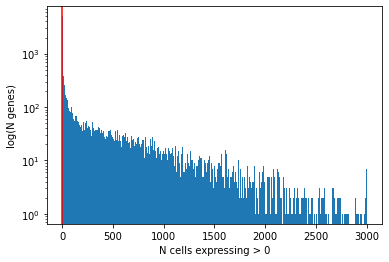

In [27]:
plt.hist(gene_qc_df['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') # for visual clarity
plt.axvline(2, color='red')
plt.yscale('log')

In [28]:
sum(gene_qc_df['n_cells_by_counts'] < 2)

4313

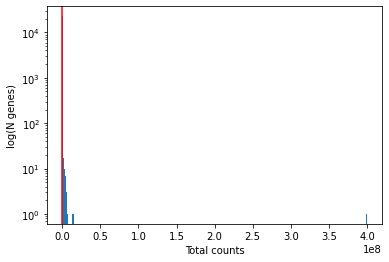

In [29]:
plt.hist(gene_qc_df['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') # for visual clarity
plt.yscale('log') 
plt.axvline(10, color='red')

In [30]:
sum(gene_qc_df['total_counts'] < 10)

4659

In [31]:
print('Started with: \n', adata)
sc.pp.filter_genes(adata, min_cells=2)
sc.pp.filter_genes(adata, min_counts=10)
print('Finished with: \n', adata)

Started with: 
 AnnData object with n_obs × n_vars = 2817 × 23433
    obs: 'tissue', 'cell_ontology_class', 'cell_ontology_term_iri', 'cell_ontology_id', 'n_genes'
    var: 'ERCC'
Finished with: 
 AnnData object with n_obs × n_vars = 2817 × 18322
    obs: 'tissue', 'cell_ontology_class', 'cell_ontology_term_iri', 'cell_ontology_id', 'n_genes'
    var: 'ERCC', 'n_cells', 'n_counts'


## Normalization

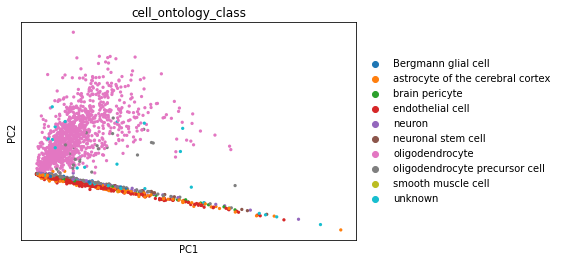

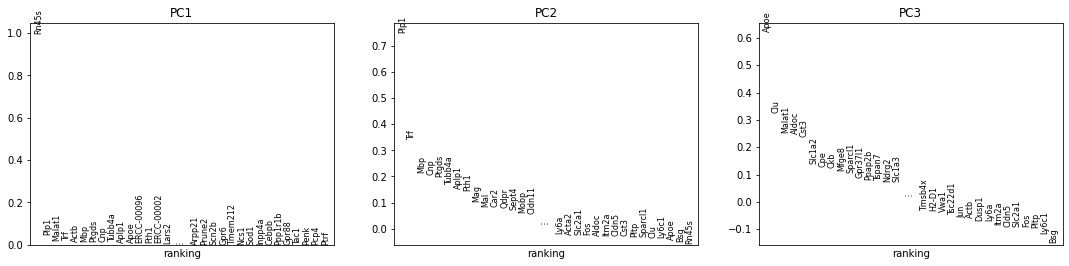

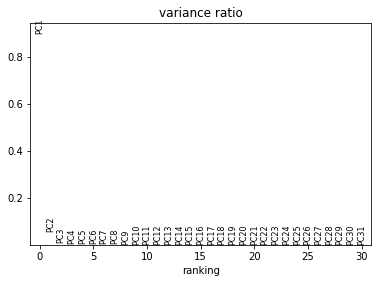

In [32]:
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='cell_ontology_class')

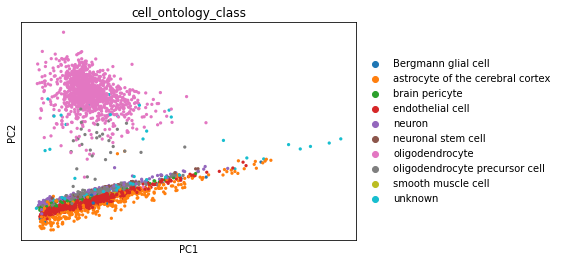

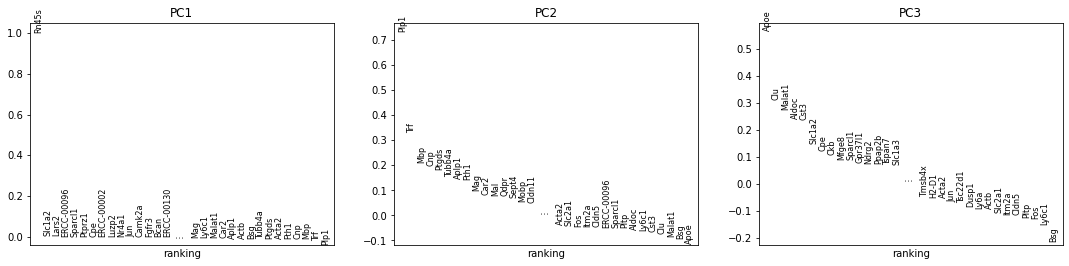

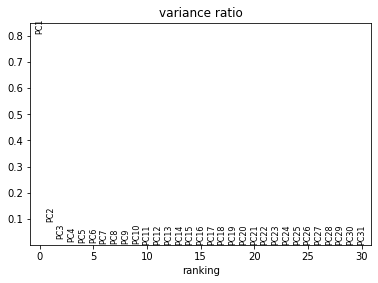

In [33]:
adata_norm1 = adata.copy()
adata_norm1.raw = adata_norm1
sc.pp.normalize_per_cell(adata_norm1, counts_per_cell_after=1e6)
sc.pp.pca(adata_norm1)
sc.pl.pca_overview(adata_norm1, color='cell_ontology_class')

In [34]:
sc.pp.log1p(adata_norm1)
sc.pp.scale(adata_norm1)

In [35]:
adata_norm1.X

array([[-0.08070888,  0.9638878 , -0.5649509 , ...,  0.22639172,
        -0.0435918 , -0.6699507 ],
       [-0.08070888,  0.16145793,  0.7690674 , ...,  2.4233947 ,
        -0.0435918 ,  1.16794   ],
       [-0.08070888, -0.12852745,  2.419497  , ..., -0.56142384,
        -0.0435918 , -0.03028773],
       ...,
       [-0.08070888, -1.165148  , -0.5649509 , ..., -0.56142384,
        -0.0435918 , -0.6699507 ],
       [-0.08070888,  0.964991  , -0.5649509 , ..., -0.56142384,
        -0.0435918 ,  1.5659395 ],
       [-0.08070888,  0.6884628 , -0.5649509 , ..., -0.56142384,
        -0.0435918 , -0.6699507 ]], dtype=float32)

In [36]:
adata_norm1.obs.head()

,tissue,cell_ontology_class,cell_ontology_term_iri,cell_ontology_id,n_genes,n_counts
cell,,,,,,
E19.MAA000538.3_8_M.1.1,Brain_Neurons,Bergmann glial cell,http://purl.obolibrary.org/obo/CL_0000644,CL:0000644,4349,316037.0
F11.MAA000538.3_8_M.1.1,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128,5018,568979.0
H11.MAA000538.3_8_M.1.1,Brain_Neurons,neuron,http://purl.obolibrary.org/obo/CL_0000540,CL:0000540,4822,328283.0
K3.MAA000538.3_8_M.1.1,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128,3084,1744183.0
O14.MAA000538.3_8_M.1.1,Brain_Neurons,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,CL:0000128,3594,267767.0


In [37]:
adata_norm1.var.head()

,ERCC,n_cells,n_counts,mean,std
0610005C13Rik,False,23,215.0,0.015788,0.195615
0610007C21Rik,False,2053,444758.0,3.777336,2.556423
0610007L01Rik,False,797,71794.0,1.095994,1.939981
0610007N19Rik,False,218,12185.0,0.286379,1.071551
0610007P08Rik,False,481,31708.0,0.601395,1.480419


In [38]:
adata_norm1.shape

(2817, 18322)

In [39]:
adata_norm1.varm['PCs'].shape

(18322, 50)

In [40]:
adata_norm1.obsm['X_pca'].shape

(2817, 50)

In [41]:
if not os.path.isdir(target_dataset):
    os.makedirs(target_dataset)
adata_norm1.write(f'{target_dataset}/normalized.h5ad')

## Dimensionality Reduction and Clustering

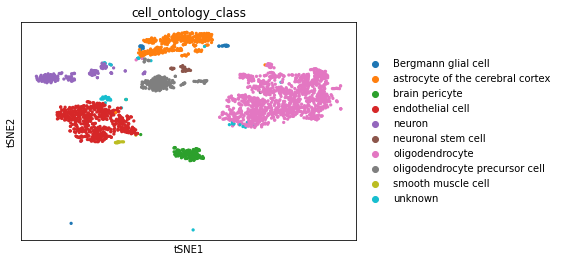

In [42]:
random_state = 666

sc.pp.pca(adata_norm1, n_comps=100)
sc.tl.tsne(adata_norm1,
           perplexity=30,
           learning_rate=1000,
           n_pcs=100,
           random_state=random_state)

sc.pl.tsne(adata_norm1, color='cell_ontology_class')

In [43]:
adata_norm1.obsm['X_tsne'].shape

(2817, 2)

In [44]:
tsne_data = {
    'TSNE-1': adata_norm1.obsm['X_tsne'][:, 0],
    'TSNE-2': adata_norm1.obsm['X_tsne'][:, 1],
    'cell_ontology_class': np.array(adata_norm1.obs['cell_ontology_class']),
}
tsne_df = pd.DataFrame(tsne_data)
tsne_df.head()

,TSNE-1,TSNE-2,cell_ontology_class
0,14.124882,57.081921,Bergmann glial cell
1,55.769539,28.146475,oligodendrocyte
2,-41.505173,26.617996,neuron
3,14.487513,-19.476603,oligodendrocyte
4,48.344398,11.904844,oligodendrocyte


In [45]:
tsne_df.to_csv(f'{target_dataset}/tsne.csv')

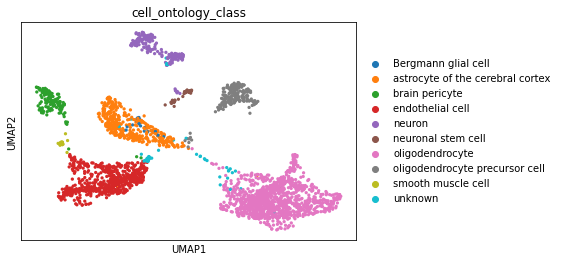

In [46]:
sc.pp.neighbors(adata_norm1)
sc.tl.umap(adata_norm1,
           random_state=random_state,
           n_components=3)

sc.pl.umap(adata_norm1, color='cell_ontology_class')

In [47]:
adata_norm1.obsm['X_umap'].shape

(2817, 3)

In [48]:
umap_data = {
    'UMAP-1': adata_norm1.obsm['X_umap'][:, 0],
    'UMAP-2': adata_norm1.obsm['X_umap'][:, 1],
    'UMAP-3': adata_norm1.obsm['X_umap'][:, 2],
    'cell_ontology_class': np.array(adata_norm1.obs['cell_ontology_class']),
}
umap_df = pd.DataFrame(umap_data)
umap_df.head()

,UMAP-1,UMAP-2,UMAP-3,cell_ontology_class
0,2.353371,2.965653,13.737680,Bergmann glial cell
1,14.358219,-3.149818,8.360369,oligodendrocyte
2,4.373765,7.990469,6.853086,neuron
3,9.944652,-2.533529,11.603137,oligodendrocyte
4,12.344387,-3.627201,10.165573,oligodendrocyte


In [49]:
umap_df.to_csv(f'{target_dataset}/umap.csv')

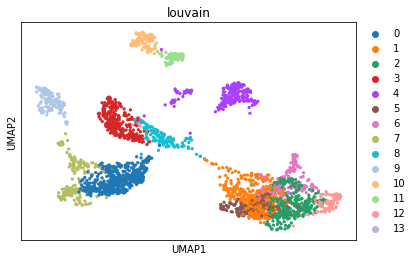

In [50]:
louvain(adata_norm1)
sc.pl.umap(adata_norm1, color='louvain')

In [51]:
louvain_data = {
    'UMAP-1': adata_norm1.obsm['X_umap'][:, 0],
    'UMAP-2': adata_norm1.obsm['X_umap'][:, 1],
    'UMAP-3': adata_norm1.obsm['X_umap'][:, 2],
    'louvain': np.array(adata_norm1.obs['louvain']),
}
louvain_df = pd.DataFrame(louvain_data)
louvain_df.head()

,UMAP-1,UMAP-2,UMAP-3,louvain
0,2.353371,2.965653,13.737680,13
1,14.358219,-3.149818,8.360369,12
2,4.373765,7.990469,6.853086,11
3,9.944652,-2.533529,11.603137,1
4,12.344387,-3.627201,10.165573,2


In [52]:
louvain_df.to_csv(f'{target_dataset}/louvain.csv')

## Autoencoder

In [53]:
adata_norm1.X.shape

(2817, 18322)

In [54]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR

torch.__version__

'1.11.0+cu102'

In [55]:
class SingleCellDataset(Dataset):
    def __init__(self, adata):
        self.adata = adata
        self.x = self.adata.X
 
    def __len__(self):
        return len(self.x)
   
    def __getitem__(self,idx):
        return self.x[idx]


dataset = SingleCellDataset(adata_norm1)

In [56]:
batch_size = 64
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
len(dataloader)

45

In [57]:
example_x = next(iter(dataloader))
example_x.shape

torch.Size([64, 18322])

In [58]:
example_x

tensor([[-0.0807,  1.2385, -0.5650,  ..., -0.5614, -0.0436,  2.2835],
        [-0.0807,  0.2384,  1.3524,  ...,  1.3766, -0.0436,  0.8522],
        [-0.0807,  0.1800, -0.5650,  ..., -0.5614, -0.0436,  1.6168],
        ...,
        [-0.0807, -1.4776, -0.5650,  ..., -0.5614, -0.0436, -0.6700],
        [-0.0807,  0.5887,  1.4737,  ..., -0.5614, -0.0436, -0.6700],
        [-0.0807, -1.4776,  0.7651,  ...,  1.8004, -0.0436,  1.0977]])

In [59]:
device = 'cuda'

In [60]:
class AutoEncoder(nn.Module):
    def __init__(self, x_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(x_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, x_dim),
        )
        
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y
        

model = AutoEncoder(adata_norm1.shape[-1]).to(device)
y = model(example_x.to(device))
y.shape

torch.Size([64, 18322])

In [61]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-4)

In [62]:
def train(dataloader, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        X_pred = model(X)
        loss = loss_fn(X_pred, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
    return torch.mean(torch.FloatTensor(losses))


EPOCHS = 1000
for epoch in range(1, EPOCHS + 1):
    loss = train(dataloader, optimizer)
    print(f'epoch {epoch} -> loss: {loss:>7f}')

epoch 1 -> loss: 0.951941
epoch 2 -> loss: 0.900535
epoch 3 -> loss: 0.891563
epoch 4 -> loss: 0.885973
epoch 5 -> loss: 0.875210
epoch 6 -> loss: 0.866732
epoch 7 -> loss: 0.887635
epoch 8 -> loss: 0.865460
epoch 9 -> loss: 0.854472
epoch 10 -> loss: 0.854372
epoch 11 -> loss: 0.860842
epoch 12 -> loss: 0.851190
epoch 13 -> loss: 0.848696
epoch 14 -> loss: 0.851648
epoch 15 -> loss: 0.858699
epoch 16 -> loss: 0.846871
epoch 17 -> loss: 0.848058
epoch 18 -> loss: 0.841614
epoch 19 -> loss: 0.841791
epoch 20 -> loss: 0.852634
epoch 21 -> loss: 0.841650
epoch 22 -> loss: 0.836441
epoch 23 -> loss: 0.838225
epoch 24 -> loss: 0.834553
epoch 25 -> loss: 0.843178
epoch 26 -> loss: 0.832650
epoch 27 -> loss: 0.838084
epoch 28 -> loss: 0.829387
epoch 29 -> loss: 0.828404
epoch 30 -> loss: 0.828756
epoch 31 -> loss: 0.835194
epoch 32 -> loss: 0.824988
epoch 33 -> loss: 0.830606
epoch 34 -> loss: 0.821156
epoch 35 -> loss: 0.823186
epoch 36 -> loss: 0.821056
epoch 37 -> loss: 0.832705
epoch 38 -

In [63]:
torch.save(model.state_dict(), f'./{target_dataset}/autoencoder.pt')

In [64]:
def encode_data(x, encoder):
    encoder.eval()
    encoded = []
    for row in x:
        r = torch.tensor(row).to(device)
        encoded.append(encoder(r).cpu().detach().numpy())
    return np.stack(encoded, axis=0)


encoded = encode_data(adata_norm1.X, model.encoder)
encoded.shape

(2817, 128)

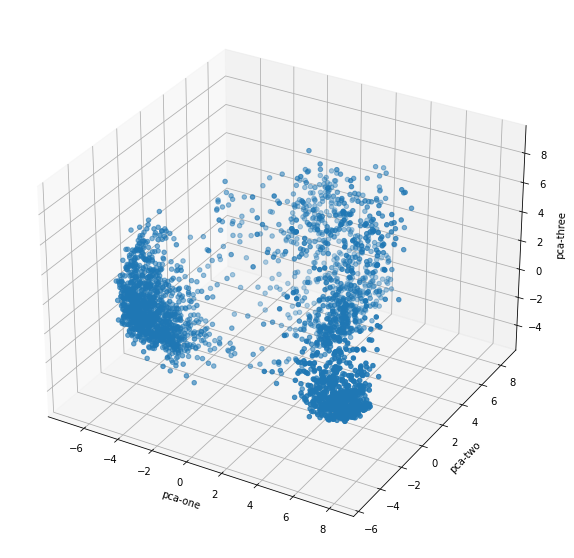

In [65]:
pca = PCA(n_components=3)
embedded_pca = pca.fit_transform(encoded)

plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
ax.scatter(
    xs=embedded_pca[:, 0],
    ys=embedded_pca[:, 1],
    zs=embedded_pca[:, 2],
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [66]:
ae_pca_data = {
    'autoencoder_pca-1': embedded_pca[:, 0],
    'autoencoder_pca-2': embedded_pca[:, 1],
    'autoencoder_pca-3': embedded_pca[:, 2],
    'cell_ontology_class': np.array(adata_norm1.obs['cell_ontology_class']),
}
ae_pca_df = pd.DataFrame(ae_pca_data)
ae_pca_df.head()

,autoencoder_pca-1,autoencoder_pca-2,autoencoder_pca-3,cell_ontology_class
0,-1.307863,5.077652,1.227670,Bergmann glial cell
1,-4.101575,-4.087380,2.212138,oligodendrocyte
2,3.685334,0.642823,6.164976,neuron
3,-3.809659,-2.035012,-2.079973,oligodendrocyte
4,-4.022608,-2.392009,-0.813007,oligodendrocyte


In [67]:
ae_pca_df.to_csv(f'{target_dataset}/ae_pca.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2817 samples in 0.000s...
[t-SNE] Computed neighbors for 2817 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2817
[t-SNE] Computed conditional probabilities for sample 2000 / 2817
[t-SNE] Computed conditional probabilities for sample 2817 / 2817
[t-SNE] Mean sigma: 2.386528
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.212563
[t-SNE] KL divergence after 1000 iterations: 0.902244


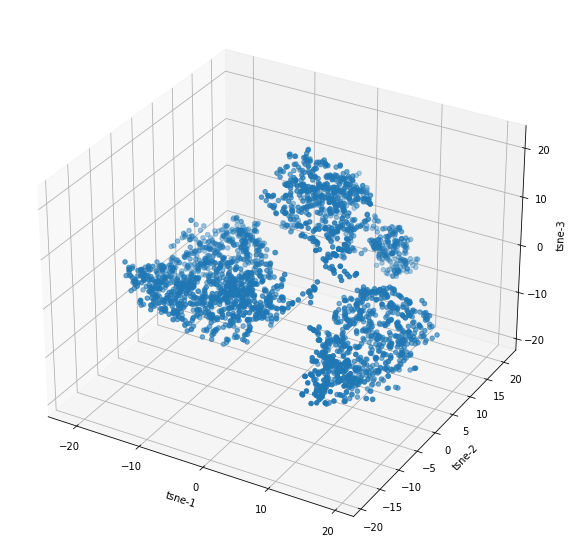

In [68]:
tsne = TSNE(n_components=3, init='random', random_state=5, verbose=1)
embedded_tsne = tsne.fit_transform(encoded)

plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
ax.scatter(
    xs=embedded_tsne[:, 0],
    ys=embedded_tsne[:, 1],
    zs=embedded_tsne[:, 2],
)
ax.set_xlabel('tsne-1')
ax.set_ylabel('tsne-2')
ax.set_zlabel('tsne-3')
plt.show()

In [69]:
ae_tsne_data = {
    'autoencoder_tsne-1': embedded_tsne[:, 0],
    'autoencoder_tsne-2': embedded_tsne[:, 1],
    'autoencoder_tsne-3': embedded_tsne[:, 2],
    'cell_ontology_class': np.array(adata_norm1.obs['cell_ontology_class']),
}
ae_tsne_df = pd.DataFrame(ae_tsne_data)
ae_tsne_df.head()

,autoencoder_tsne-1,autoencoder_tsne-2,autoencoder_tsne-3,cell_ontology_class
0,-3.370450,1.118370,15.314832,Bergmann glial cell
1,-19.900513,0.185295,-7.400536,oligodendrocyte
2,7.207797,12.840722,0.774300,neuron
3,0.511416,-9.333393,-0.109645,oligodendrocyte
4,-9.278993,-4.708510,6.344439,oligodendrocyte


In [70]:
ae_tsne_df.to_csv(f'{target_dataset}/ae_tsne.csv')